## DTSA-5511 - Week 3: Kaggle Mini Project
### Histopathologic Cancer Detection

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, BatchNormalization, Flatten, Concatenate
from tensorflow.keras.layers import MaxPool2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import Model, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.applications.densenet import DenseNet169

In [2]:
print('Tensorflow version:', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Problem Description and the Dataset
In this project, we creates an algorithm to detect metastatic cancer from small patches taken from larger digital pathology scans. The histopathological image dataset comes from Kaggle, it is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. The original PCam contains duplicate images due to its probabilistic sampling. This version, presented on Kaggle, does not contain duplicates.

Examining histopathologic slides manually is a tedious and time-consuming task, as a large area of tissue has to be examined and small metastases can be easily missed, thus making it an ideal prospect for automation using machine learning techniques.

In the dataset, we are provided with a large number of small pathology images to classify. 
* Files are named with an image ID.
* The train_labels.csv file provides the ground truth for the images in the train folder.
* A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.
* Tumor tissue in the outer region of the patch does not influence the label.
* This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
* We are predicting the labels for the images in the test folder.

## 2. Exploratory Data Analysis

In [40]:
train_path = 'data/train/'
test_path = 'data/test/'
labels_path = 'data/train_labels.csv'
labels = pd.read_csv(labels_path)

In [43]:
print('Number of training images:', len([os.path.join(train_path, f) for f in os.listdir(train_path)]))
print('Number of testing images:', len([os.path.join(test_path, f) for f in os.listdir(test_path)]))

Number of training images: 220025
Number of testing images: 57458


**Image File Descriptor:**
***
| **<center>DESCRIPTION** |  |
| ------ | ------- |
| **<center>Format** | **<center>TIF** |
| **<center>Size** | **<center>96 x 96** |
| **<center>Channels** | **<center>3** |
| **<center>Bits Per Channel** | **<center>8** |
| **<center>Data Type** | **<center>Unsigned Char** |
| **<center>Compression** | **<center>JPEG** |
***

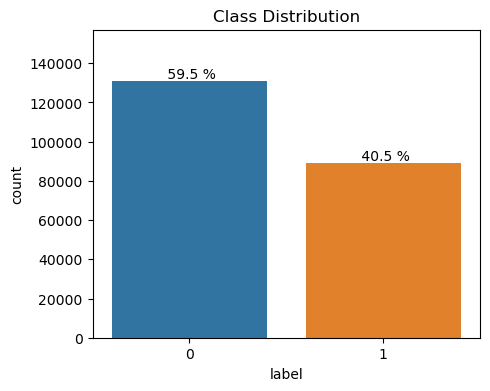

In [36]:
plt.figure(figsize=(5, 4))
total = labels['label'].count()
ax = sns.countplot(data=labels, x='label', width=0.8)
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100 : 0.1f} %')
ax.margins(y=0.2)
plt.title('Class Distribution');

Malignant (cancerous) samples make up 40.5% of the dataset, while benign (non-cancerous) samples make up the remaining 59.5%. This is slightly imbalance; however, it is not imbalanced enough to warrant further operations.

Let's take a look at what the images look like.

In [34]:
pos_samples = labels.loc[labels['label'] == 1].sample(5)
neg_samples = labels.loc[labels['label'] == 0].sample(5)
pos_imgs = []
neg_imgs = []

for id in pos_samples['id']:
    path = os.path.join(train_path, id + '.tif')
    img = plt.imread(path)
    pos_imgs.append(img)

for id in neg_samples['id']:
    path = os.path.join(train_path, id + '.tif')
    img = plt.imread(path)
    neg_imgs.append(img)

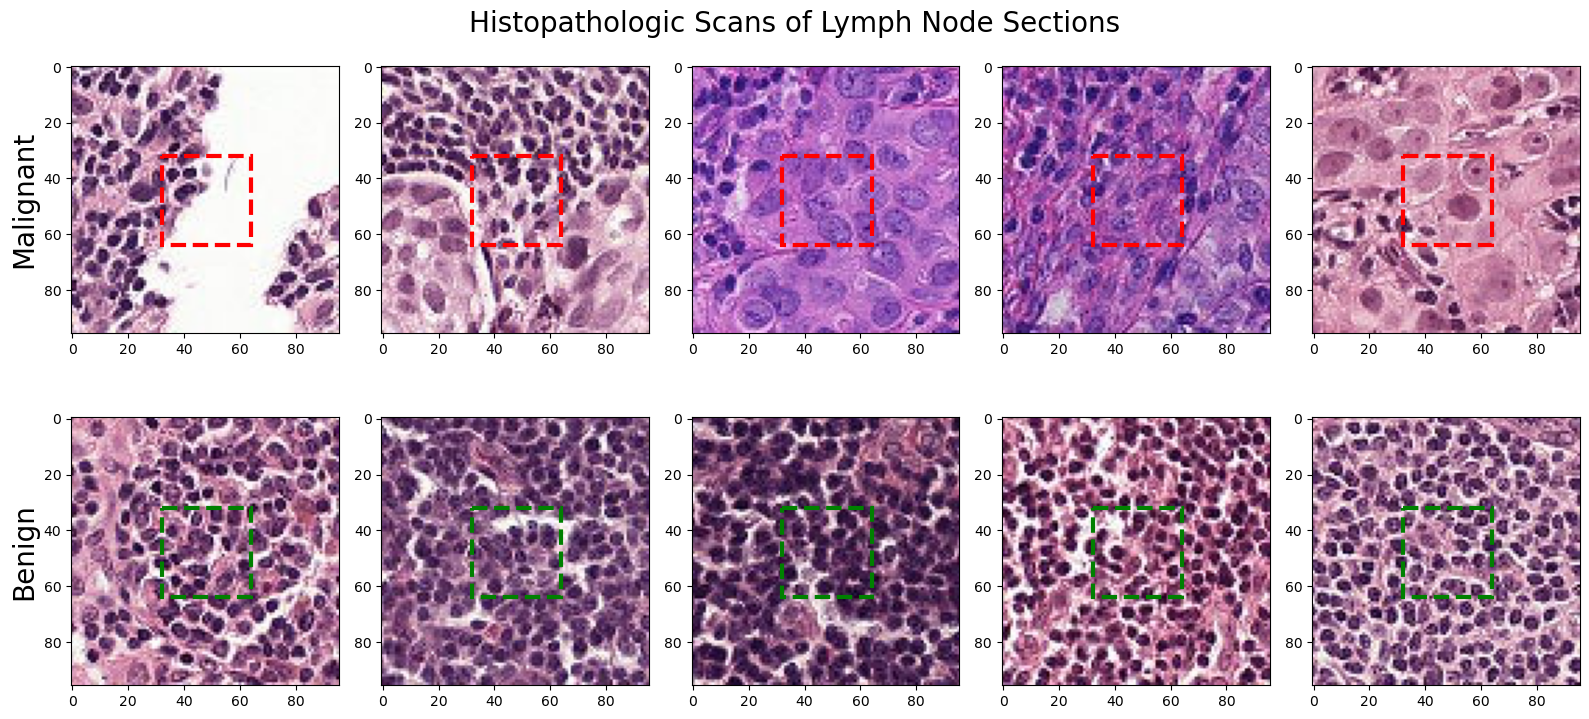

In [35]:
fig, axs = plt.subplots(2, 5, figsize=(16, 8))
fig.suptitle('Histopathologic Scans of Lymph Node Sections', fontsize=20, y=0.93)
for i, img in enumerate(pos_imgs):
    axs[0, i].imshow(img)
    bbox = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='r', facecolor='none', linestyle='--')
    axs[0, i].add_patch(bbox)
axs[0, 0].set_ylabel('Malignant', fontsize=20)

for i, img in enumerate(neg_imgs):
    axs[1, i].imshow(img)
    bbox = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='green', facecolor='none', linestyle='--')
    axs[1, i].add_patch(bbox)
axs[1, 0].set_ylabel('Benign', fontsize=20)
plt.tight_layout()

We can see that it is quite a challenge to distinguish whether an image should be classified as malignant or non-malignant simply from an inspection. These images contain intricate details that may not be easily discernible. A highly trained pathologists must carefully analyze each image to make an accurate diagnosis, and this is very time consuming, which can further result in delays in treatment.

### 2.1. The Plan
* The dataset is relatively small. Therefore, to avoid overfitting, we apply image augmentation during training using the ImageDataGenerator from Keras. Additionally, as discussed in the lecture, strategies such as L1/L2 regularization, dropout, and batch normalization can also be utilized to reduce overfitting.

* On each epoch, the ImageDataGenerator applies a random transformation within the ranges that are supplied independently. The set of transformations includes randomly fliping images horizontally and or vertically, randomly rotate between 0 and 5 degrees, randomly zoom up to 10%, and randomly shift width and or height by up to 10%.

* By using image augmentation, the learned model may be more robust and accurate as it is trained on different variations of the same image.
  
* Since we are predicting a probability that the center 32x32px region of a patch contains at least one pixel of tumor tissue, wouldn't it make sense to crop our image to that region only? This can be confirmed by training using both center-cropped images and uncropped images.

* Augmentations will also be applied when we are predicting (making inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions.

In [4]:
from tensorflow.keras.preprocessing import image

# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(horizontal_flip=True,   # Randomly flip images horizontally
                             vertical_flip=True,     # Randomly flip images vertically
                             rotation_range=5,       # Random rotation between 0 and 5 degrees
                             zoom_range=0.1,         # Zoom randomly up to 10%
                             width_shift_range=0.1,  # Randomly shift width by up to 10%
                             height_shift_range=0.1, # Randomly shift height by up to 10%
                             #shear_range=0.2,       # Shear intensity
                             fill_mode='nearest')    # Strategy for filling in newly created pixels, default='nearest'

# pick a random original image to be augmented
img_path = 'data/train/000b35e7c39c6cb32224dcb3fe4c48acf34f0252.tif'

img = image.load_img(img_path, target_size=(96, 96, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)   # dimension: (1, 96, 96, 3)

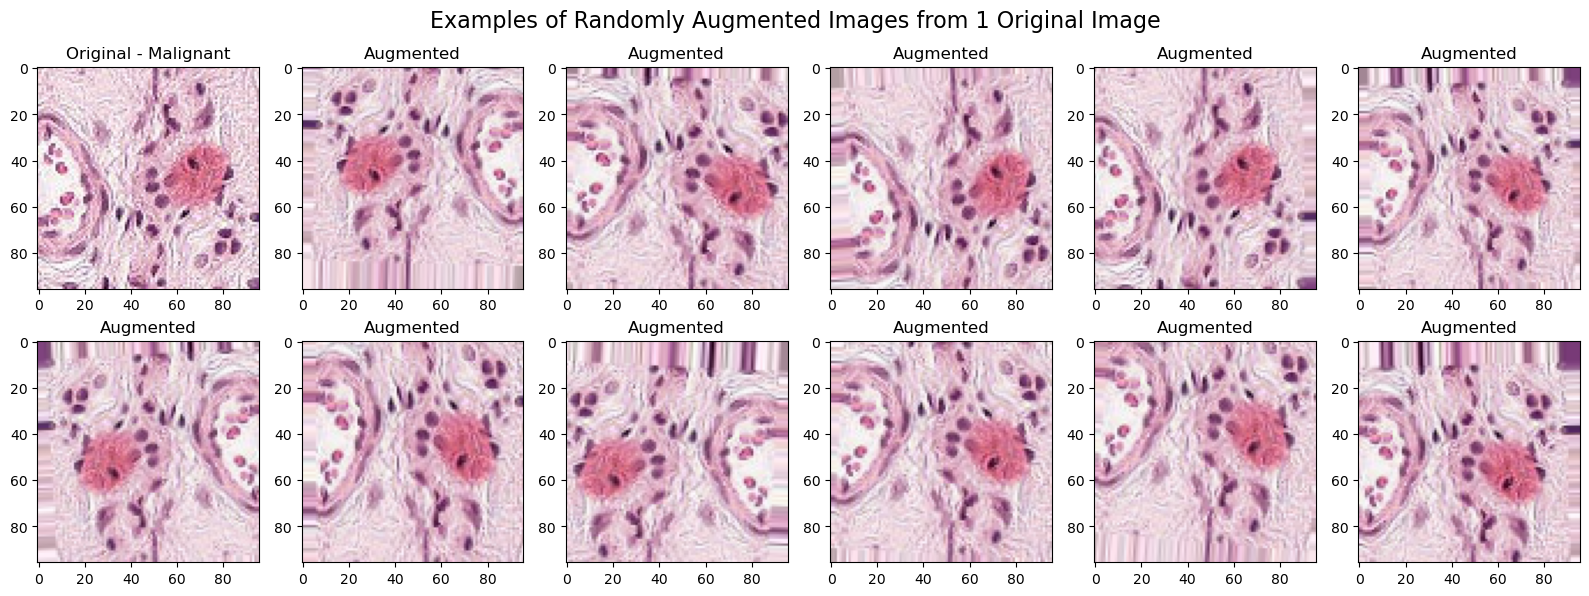

In [5]:
i = 1
plt.figure(figsize=(16, 6))
plt.suptitle('Examples of Randomly Augmented Images from 1 Original Image', fontsize=16)
plt.subplot(2, 6, i)
plt.imshow(img)
plt.title('Original - Malignant')
for batch in datagen.flow(x, batch_size=1):
    i += 1
    plt.subplot(2, 6, i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title('Augmented')
    if i % 12 == 0:
        break
plt.tight_layout()

## 3. Model Architecture
To establish a baseline, we'll begin with a relatively simple model. Convolutional Neural Network will be used for feature extraction, and classification will be done using Fully Connected Artificial Neural Network. Initially, we'll train classic networks such as LeNet5, and subsequently, we'll try to construct a custom CNN model.

Later on we will utilize transfer learning and fine-tune a pre-trained model to our dataset. The base model we will be experimenting with is DenseNet169. 
* Fine-Tuning: Unfreeze a few of the top layers of a frozen base model and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for our task.

In addition to implementing various architectures and hyperparameters, each model will incorporate a specific choice of architecture:
* Activations:
   * ReLU: it introduces non-linearity to the network by mapping negative values to zero and leaving positive values unchanged.
   * Sigmoid: this is for the output layer, it maps any real-valued number to the range [0, 1], this property makes it suitable for our binary classification task.
* Loss function: Binary crossentropy
* Optimizer: Adam (Adaptive Moment Estimation), Adam adapts the learning rates for each parameter during training, it's known for its robustness and efficiency.
* Batch size: I've selected 256 after observing the choices made by several Kaggle users. This size strikes a balance, neither too small nor too large.
* Dropout: dropout rate is 0.5; this rate is often considered a good starting point and has been found to be effective in many applications.
* Metrics: ROC AUC (Area Under the Curve) score. Kaggle utilizes this metric to evaluate submissions. Therefore, I've included this metric during model compilation, allowing us to monitor its value, in addition to loss and accuracy, during the training session.
* Number of epochs: I've set this to 50, taking into account that I'll be implementing reduce learning rate on plateau and early stopping in the Keras model.

For hyperparameter tuning:
* Center-crop images sized at (32, 32, 3) will be utilized. With smaller images, we have fewer parameters to train.
* We will train with only 100,000 images, approximately half the number of training images.
* Set epoch to 10 instead of 50; if something seems off or if the model isn't learning as expected, we can make adjustments sooner.

This approach will make hyperparameter tuning feasible; otherwise, it would be very time-consuming.

Let's define each of our models architecture now.

### 3.1. Convolutional Neural Network (CNN) Model
Why CNN?

CNN exploit the spatial structure of images by using convolutional layers that apply filters across small regions of the image. This allows them to capture local patterns and features such as edges, textures, and shapes.

The filters are the collection of weights, it is called learnable filters that updates its values as we train. This weights are shared across the image. It's not like one pixel to pixel weights, but it's more of the feature finder, that can move around the image, slide around the image, and then find the features. 

This weight sharing aspect significantly reduces the number of parameters, making CNN more effective and efficient in computer vision task, such as histopathologic cancer detection.

### 3.1.1 LeNet5 Model
Before constructing our custom CNN model, let's first take a look at the classic LeNet5 architecture, one of the earliest pre-trained model which was created by Yann LeCunn in 1998. 

It consists of 2 Convolutional-Pooling layers, followed by 2 Fully Connected (Dense) layers, and finally the output layer with sigmoid activation function.

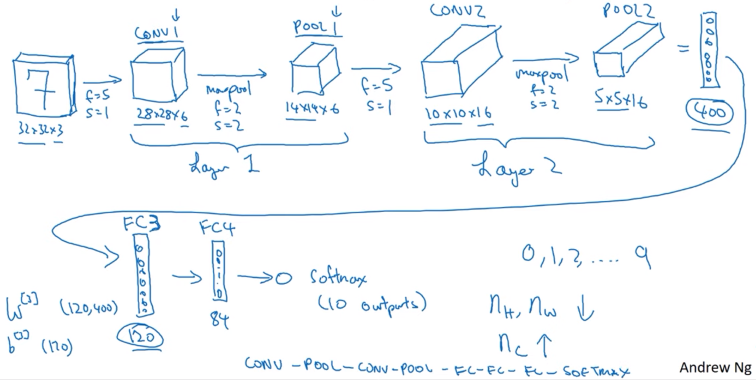

LeNet5 was primarily designed for handwritten digit recognition tasks, such as the classification of digits in the MNIST dataset (10 classes). Although it may not be the best choice for our medical image classification task, it has a relatively simple architecture and I think it will be good for a baseline model.

### 3.1.2. Build Custom CNN Model
This model will follow the trend in networks architecture.

* For the Convolutional layers, I will use Conv-Conv-Pool-Conv-Conv-Pool configuration, with 32 and 64 filters, respectively.
* Convolutional layers are adept at extracting spatial hierarchies of features from the image data. By the time it reaches the Dense layers, it has already undergone substantial feature extraction.
* For the Fully Connected or Dense layers: either Dense(128)-Dense(64) or Dense(256)-Dense(128). We'll experiment with both configurations to determine which one gives the best results.
* Output Layer: Dense(1) with sigmoid activation

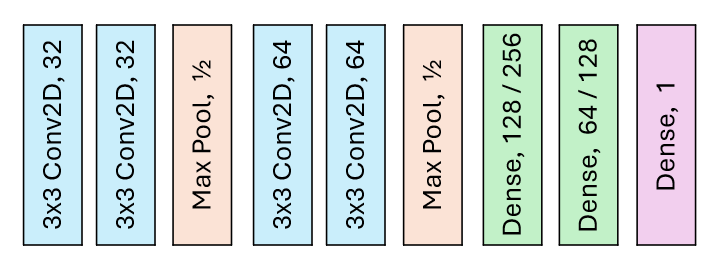

### 3.2. Transfer Learning
Why Transfer Learning?
* Transfer learning is a technique where a model trained on one task is repurposed for another related task. Instead of starting the learning process from scratch, transfer learning leverages knowledge gained from solving one problem and applies it to a different but related problem.

* Keras application module has models that are made available alongside pre-trained weights [Link here]('https://keras.io/api/applications/'). DenseNet169 is deeper and wider than some other architectures like ResNet50 or VGG19. However it has less number of parameters because of its dense connectivity pattern. Therefore I chose to use DenseNet169 for the base model.

* DenseNet169 are trained on ImageNet dataset which primarily consists of natural images (natural scenes, objects, animals, human-made objects, artwork, and other diverse visual concepts). Medical images such as histopathologic scans of lymph node have distinct characteristics and challenges compared to images from ImageNet. Therefore I will fine tune some of the DenseNet169's top layers. 

* The earlier (bottom) layers pick up small, general patterns, with later (top) layers picking up larger and more complex features. I will fine tune the last 2 layers (Convolutional layer 4 and Convolutional layer 5).

* Fine-tuning begins with migrating the weights from the pre-trained model. We then replace the last fully connected layers of the pre-trained DenseNet169 with 2 fully connected layers (128 nodes - 64 nodes), and 1 output layer (1 node).

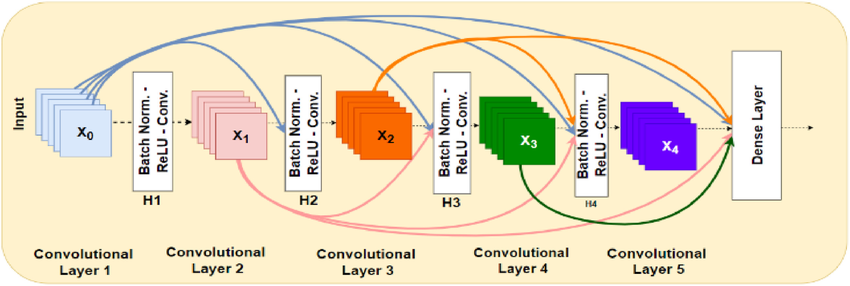

In [46]:
resnet50 = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
densenet169 = DenseNet169(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
vgg19 = VGG19(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 14s 0us/step


In [47]:
def get_num_trainable(model, model_name):
    total_trainable_params = sum(tf.size(p) for p in model.trainable_variables)
    print("Number of trainable parameters in {}: {}".format(model_name, total_trainable_params))

In [50]:
get_num_trainable(resnet50, 'ResNet50')
get_num_trainable(densenet169, 'DenseNet169')
get_num_trainable(vgg19, 'VGG19')

Number of trainable parameters in ResNet50: 23534592
Number of trainable parameters in DenseNet169: 12484480
Number of trainable parameters in VGG19: 20024384


In [17]:
resnet50 = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
densenet169 = DenseNet169(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
vgg19 = VGG19(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

In [18]:
print('Number of layers in ResNet50:', len(resnet50.layers))
print('Number of layers in DenseNet169:', len(densenet169.layers))
print('Number of layers in VGG19:', len(vgg19.layers))

Number of layers in ResNet50: 175
Number of layers in DenseNet169: 595
Number of layers in VGG19: 22


As we can see, DenseNet169 is deeper (595 layers compare to 175 of ResNet50, and 22 of VGG19), and yet has less number of trainable parameters.

Let's now define several utilities functions before implementing our models.

### 3.3. DataGenerator Class - Data Augmentation, Trainer and Plotting Functions
* We first split train dataset into train and test (90:10 split), then we further split the test data into test and valid (50:50 split). 
* Normalize the data by dividing with 255.
* Image data augmentations are applied during training time using the ImageDataGenerator supplied by Keras. There are several transformations available. I picked:
   * Random horizontal and vertical flip
   * Random rotation: 0 to 5 degrees
   * Random zoom: 0 - 10 %
   * Random translation: randomly shifting the image in both height and width directions: 0 - 10 %

In [6]:
def crop_center(img):
    """
    Custom crop-center function for ImageDataGenerator
    """
    h, w = img.shape[0], img.shape[1]
    top = (h - 32) // 2
    left = (w - 32) // 2
    bottom = top + 32
    right = left + 32
    cropped_img = img[top:bottom, left:right, :]
    return cropped_img

class DataGenerator():
    def __init__(self, img_size, batch_size, preprocessing_func=None, tuning=False):
        self.img_size = img_size
        self.batch_size = batch_size
        
        train_path = 'data/train/'
        test_path = 'data/test/'
        labels = pd.read_csv('data/train_labels.csv')

        tif_files = [os.path.join(train_path, f) for f in os.listdir(train_path) if f.endswith('.tif')]
        df = pd.DataFrame({'path': tif_files})
        df['id'] = df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
        df = df.merge(labels, on='id')
        df['label'] = df['label'].astype(str)

        # for testing/hyperparameters tuning purposes, only use 100,000 data for speed
        if tuning:
            df = df[:100000]

        train, test = train_test_split(df, test_size=0.1, stratify=df['label'])     # used test_size=0.25 for hyperparams tuning
        test, valid = train_test_split(test, test_size=0.5, stratify=test['label'])

        train_image_generator = ImageDataGenerator(preprocessing_function=preprocessing_func,
                                                   rescale = 1./255,
                                                   vertical_flip = True, 
                                                   horizontal_flip = True,
                                                   rotation_range = 5,
                                                   zoom_range = 0.1,
                                                   width_shift_range = 0.1,
                                                   height_shift_range = 0.1)
        
        test_image_generator = ImageDataGenerator(preprocessing_function=preprocessing_func,
                                                  rescale = 1./255)

        self.train_data_generator = train_image_generator.flow_from_dataframe(
            dataframe = train,
            directory = None,
            x_col = 'path',
            y_col = 'label',
            target_size = (self.img_size, self.img_size),
            class_mode = 'binary',
            batch_size = self.batch_size,
            seed = 42,
            shuffle = True)

        self.valid_data_generator = train_image_generator.flow_from_dataframe(
            dataframe = valid,
            directory = None,
            x_col = 'path',
            y_col = 'label',
            target_size = (self.img_size, self.img_size),
            class_mode = 'binary',
            batch_size = self.batch_size,
            shuffle = True)

        self.test_data_generator = test_image_generator.flow_from_dataframe(
            dataframe = test,
            directory = None,
            x_col = 'path',
            y_col = 'label',
            target_size = (self.img_size, self.img_size),
            class_mode = 'binary',
            batch_size = 1,
            shuffle = False)

**Note**: In Callbacks:
* `patience`: the number of epochs to wait before early stop if no progress on the validation set.

In [7]:
def trainer(model, lr, img_size, batch_size, preprocessing_func, filename, n_epoch, tuning=False):
    np.random.seed(42)
    tf.random.set_seed(42)

    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    
    path = './best_weights_' + filename + '.hdf5'
    
    save_callback = ModelCheckpoint(filepath=path, monitor='val_accuracy', mode='max',
                    save_best_only=True, verbose=1)
    
    early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max',
                                           patience=5, verbose=1)

    print('ImageDataGenerator ..')
    data = DataGenerator(img_size=img_size, batch_size=batch_size, preprocessing_func=preprocessing_func, tuning=tuning)

    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=lr),
             metrics=['accuracy', metrics.AUC()])

    print('\nTraining the model ..')
    history = model.fit(data.train_data_generator, validation_data=data.valid_data_generator,
                        epochs=n_epoch, 
                        steps_per_epoch=data.train_data_generator.n // data.train_data_generator.batch_size,
                        validation_steps=data.valid_data_generator.n // data.valid_data_generator.batch_size,
                        callbacks=[reduce_lr_callback, early_stopping_callback, save_callback],
                        verbose=1)
    
    print('\nPredicting test data ..')
    predictions = model.predict(data.test_data_generator, verbose=1)

    fpr, tpr, thresholds = roc_curve(data.test_data_generator.classes, predictions)
    roc_auc = auc(fpr, tpr)

    print('\nSaving metrics at {}'.format(filename+'-metrics.npz'))
    np.savez(file=filename+'-metrics.npz', loss=history.history['loss'], accuracy=history.history['accuracy'],
             roc_auc=roc_auc, fpr=fpr, tpr=tpr, thresholds=thresholds)

    return model, data, history, fpr, tpr, roc_auc

In [8]:
def plot_all(history, title, fpr, tpr, roc_auc):
    m = len(history.history['accuracy']) + 1
    epochs = np.arange(1, m)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    plt.suptitle(title, fontsize=16)
    axs[0].plot(epochs, history.history['accuracy'], label='train')
    axs[0].plot(epochs, history.history['val_accuracy'], label='valid')
    axs[0].set_ylim((0, 1))
    axs[0].legend(loc='lower left', facecolor='white', framealpha=0.5)
    axs[0].set_ylabel('Accuracy')
    
    axs[1].plot(epochs, history.history['loss'], label='train')
    axs[1].plot(epochs, history.history['val_loss'], label='valid')
    axs[1].set_ylim((0, 1))
    axs[1].legend(loc='upper right', facecolor='white', framealpha=0.5)
    axs[1].set_ylabel('Log Loss')

    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %.2f)' % roc_auc)
    axs[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].set_title('Test Data ROC Curve')
    axs[2].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show() 

## 4. Results and Analysis

### 4.1. LeNet5
We will tune the learning rate. Learning rate are typically small for Adam optimizer, so we'll start from 0.002, and half the learning rate after that.

In [40]:
lr_list = [0.002, 0.001, 0.0005]

In [83]:
# Create empty dataframe for storing hyperparameter tuning results
df_tuningresult = pd.DataFrame({'val_loss': [], 'val_accuracy': [], 'val_auc': []})

In [7]:
def LeNet5(inputshape):
    tf.keras.backend.clear_session()
    model = Sequential(name='LeNet5')
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=inputshape, padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [77]:
lenet5_lr1 = LeNet5((32, 32, 3))
lenet5_lr1.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               48120

In [78]:
lenet5_lr1, data, history, fpr, tpr, roc_auc =  trainer(lenet5_lr1, lr=lr_list[0], img_size=32, batch_size=256, preprocessing_func=crop_center, filename='lenet5_lr1', n_epoch=10, tuning=True)

ImageDataGenerator ..
Found 75000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/10
292/292 [==============================] - 60s 204ms/step - loss: 0.5627 - accuracy: 0.7124 - auc: 0.7688 - val_loss: 0.5086 - val_accuracy: 0.7532 - val_auc: 0.8304
Epoch 2/10
292/292 [==============================] - 55s 188ms/step - loss: 0.4960 - accuracy: 0.7649 - auc: 0.8306 - val_loss: 0.4862 - val_accuracy: 0.7730 - val_auc: 0.8438
Epoch 3/10
292/292 [==============================] - 56s 193ms/step - loss: 0.4844 - accuracy: 0.7727 - auc: 0.8391 - val_loss: 0.4878 - val_accuracy: 0.7701 - val_auc: 0.8517
Epoch 4/10
292/292 [==============================] - 56s 191ms/step - loss: 0.4720 - accuracy: 0.7808 - auc: 0.8482 - val_loss: 0.5012 - val_accuracy: 0.7641 - val_auc: 0.8301
Epoch 5/10
292/292 [==============================] - 56s 190

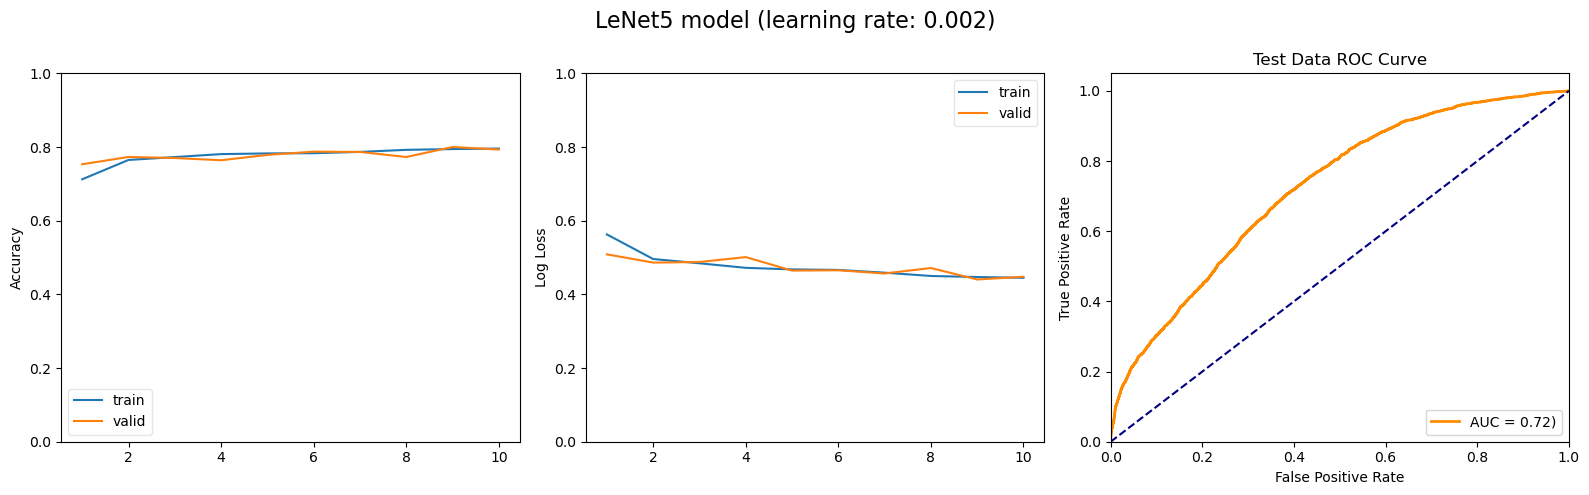

In [79]:
plot_all(history, 'LeNet5 model (learning rate: 0.002)', fpr, tpr, roc_auc)

In [84]:
# Store result for lr=0.002
df_history = pd.DataFrame(history.history)
data_series = df_history[['val_loss', 'val_accuracy', 'val_auc']].iloc[-1]

# Add the this result (last values) to df_tuningresult
df_tuningresult = pd.concat([df_tuningresult, data_series.to_frame().T], ignore_index=True)

Next, we fit LeNet5 model with learning rate = 0.001

In [90]:
lenet5_lr2 = LeNet5((32, 32, 3))
lenet5_lr2, data, history, fpr, tpr, roc_auc =  trainer(lenet5_lr2, lr=lr_list[1], img_size=32, batch_size=256, preprocessing_func=crop_center, filename='lenet5_lr2', n_epoch=10, tuning=True)

ImageDataGenerator ..
Found 75000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/10
292/292 [==============================] - 60s 205ms/step - loss: 0.5359 - accuracy: 0.7351 - auc: 0.7970 - val_loss: 0.4978 - val_accuracy: 0.7664 - val_auc: 0.8315
Epoch 2/10
292/292 [==============================] - 57s 195ms/step - loss: 0.4983 - accuracy: 0.7655 - auc: 0.8286 - val_loss: 0.4805 - val_accuracy: 0.7761 - val_auc: 0.8427
Epoch 3/10
292/292 [==============================] - 58s 199ms/step - loss: 0.4794 - accuracy: 0.7788 - auc: 0.8428 - val_loss: 0.4957 - val_accuracy: 0.7701 - val_auc: 0.8426
Epoch 4/10
292/292 [==============================] - 57s 197ms/step - loss: 0.4693 - accuracy: 0.7831 - auc: 0.8500 - val_loss: 0.4757 - val_accuracy: 0.7804 - val_auc: 0.8521
Epoch 5/10
292/292 [==============================] - 58s 199

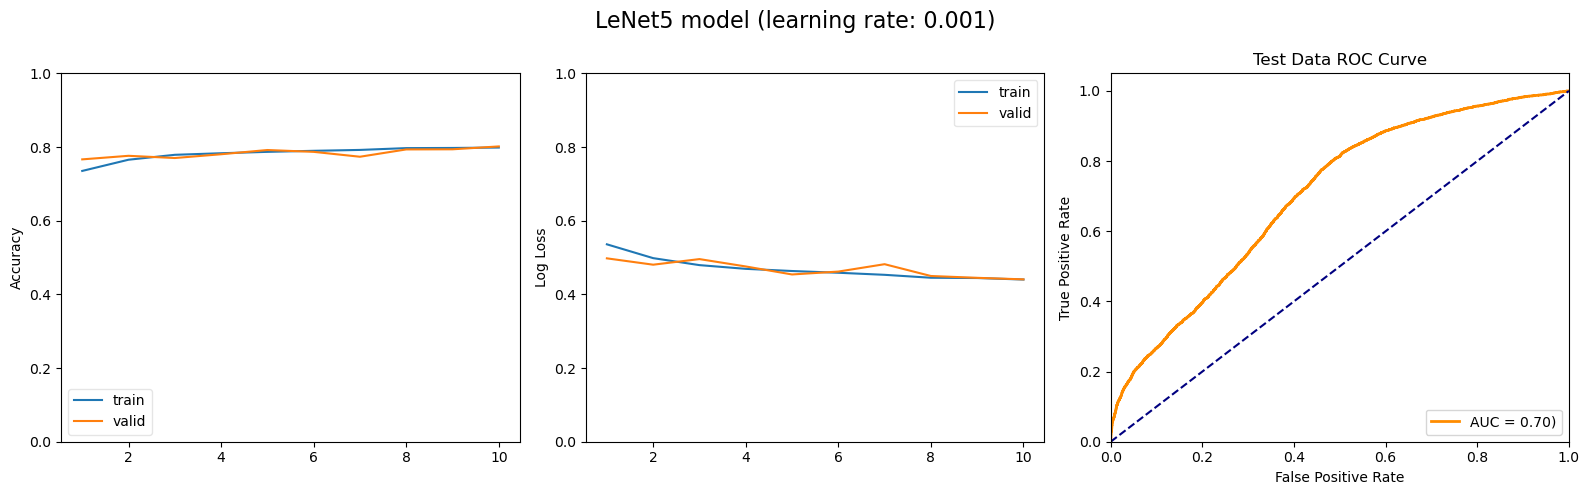

In [91]:
plot_all(history, 'LeNet5 model (learning rate: 0.001)', fpr, tpr, roc_auc)

In [100]:
# Store result for lr=0.001
df_history = pd.DataFrame(history.history)
data_series = df_history[['val_loss', 'val_accuracy', 'val_auc']].iloc[-1]

# Add the this result (last values) to df_tuningresult
df_tuningresult = pd.concat([df_tuningresult, data_series.to_frame().T], ignore_index=True)

Lastly, we fit LeNet5 model with learning rate = 0.0005

In [103]:
lenet5_lr3 = LeNet5((32, 32, 3))
lenet5_lr3, data, history, fpr, tpr, roc_auc =  trainer(lenet5_lr3, lr=lr_list[2], img_size=32, batch_size=256, preprocessing_func=crop_center, filename='lenet5_lr2', n_epoch=10, tuning=True)

ImageDataGenerator ..
Found 75000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/10
292/292 [==============================] - 60s 205ms/step - loss: 0.5461 - accuracy: 0.7293 - auc: 0.7886 - val_loss: 0.5016 - val_accuracy: 0.7628 - val_auc: 0.8287
Epoch 2/10
292/292 [==============================] - 57s 196ms/step - loss: 0.5027 - accuracy: 0.7587 - auc: 0.8258 - val_loss: 0.4953 - val_accuracy: 0.7673 - val_auc: 0.8320
Epoch 3/10
292/292 [==============================] - 57s 195ms/step - loss: 0.4935 - accuracy: 0.7659 - auc: 0.8326 - val_loss: 0.4875 - val_accuracy: 0.7710 - val_auc: 0.8366
Epoch 4/10
292/292 [==============================] - 57s 194ms/step - loss: 0.4850 - accuracy: 0.7701 - auc: 0.8389 - val_loss: 0.4856 - val_accuracy: 0.7673 - val_auc: 0.8422
Epoch 5/10
292/292 [==============================] - 57s 196

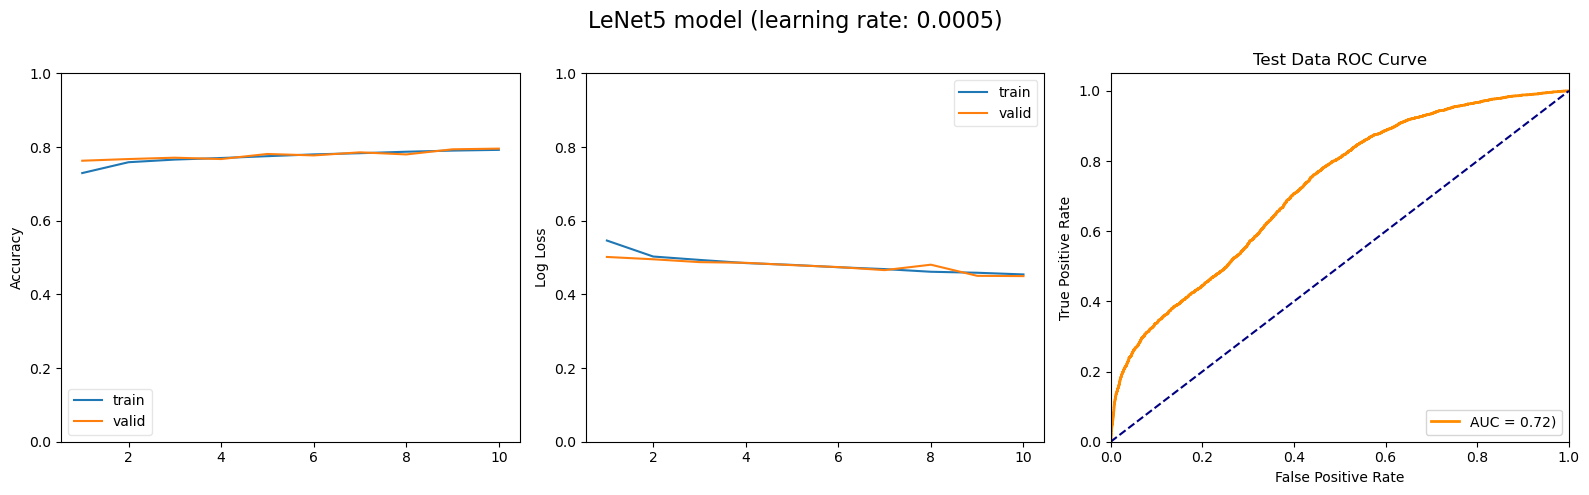

In [104]:
plot_all(history, 'LeNet5 model (learning rate: 0.0005)', fpr, tpr, roc_auc)

In [106]:
# Store result for lr=0.0005
df_history = pd.DataFrame(history.history)
data_series = df_history[['val_loss', 'val_accuracy', 'val_auc']].iloc[-1]

# Add the this result (last values) to df_tuningresult
df_tuningresult = pd.concat([df_tuningresult, data_series.to_frame().T], ignore_index=True)

### LeNet5 Hyperparameter Tuning Result
Based on the tuning results and visualization below, all three learning rate values appear comparable. I've chosen to utilize a learning rate of 0.002, considering we are adding the ReduceLROnPlateau() method into the Keras Callbacks.

In [108]:
model_name = ['LeNet5-lr-0.002', 'LeNet5-lr-0.001', 'LeNet5-lr-0.0005']
df_tuningresult.insert(0, 'Model Name', model_name)
df_tuningresult

Model Name  val_loss  val_accuracy   val_auc
0   LeNet5-lr-0.002  0.447748      0.793213  0.872157
1   LeNet5-lr-0.001  0.440756      0.801595  0.871727
2  LeNet5-lr-0.0005  0.449562      0.795654  0.864637

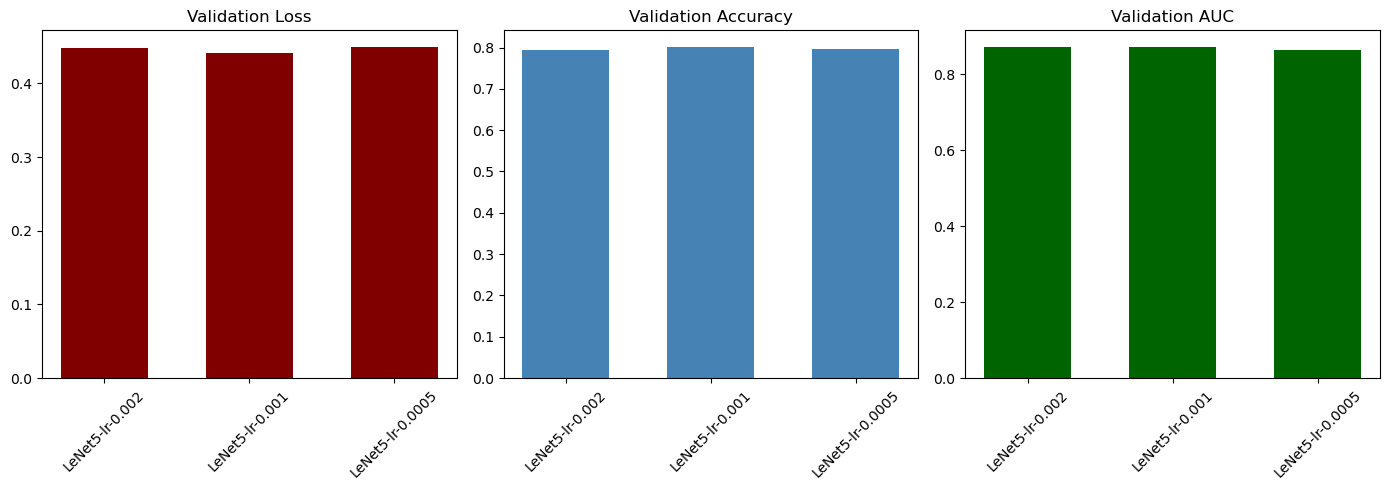

In [117]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.bar(df_tuningresult['Model Name'], df_tuningresult['val_loss'], color ='maroon', width=0.6)
plt.title('Validation Loss')
plt.xticks(range(3), model_name, rotation=45)

plt.subplot(1, 3, 2)
plt.bar(df_tuningresult['Model Name'], df_tuningresult['val_accuracy'], color ='steelblue', width=0.6)
plt.title('Validation Accuracy')
plt.xticks(range(3), model_name, rotation=45)

plt.subplot(1, 3, 3)
plt.bar(df_tuningresult['Model Name'], df_tuningresult['val_auc'], color ='darkgreen', width=0.6)
plt.title('Validation AUC')
plt.xticks(range(3), model_name, rotation=45)

plt.tight_layout()
plt.show()

I have also confirmed that the ROC curve area for the model trained with uncropped images is better than those trained on crop-center images. Hence, we will train our models with uncropped images for Kaggle submission.

In [12]:
lenet5= LeNet5((96, 96, 3))
lenet5.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7056)              0         
                                                                 
 dense (Dense)               (None, 120)               84684

In [13]:
lenet5, data, history, fpr, tpr, roc_auc =  trainer(lenet5, lr=0.002, img_size=96, batch_size=256, preprocessing_func=None, filename='lenet5', n_epoch=50, tuning=False)

ImageDataGenerator ..
Found 198022 validated image filenames belonging to 2 classes.
Found 11002 validated image filenames belonging to 2 classes.
Found 11001 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/50
773/773 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.7385 - auc: 0.8014
Epoch 1: val_accuracy improved from -inf to 0.78767, saving model to .\best_weights_lenet5.hdf5
773/773 [==============================] - 721s 923ms/step - loss: 0.5321 - accuracy: 0.7385 - auc: 0.8014 - val_loss: 0.4737 - val_accuracy: 0.7877 - val_auc: 0.8516 - lr: 0.0020
Epoch 2/50
773/773 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7875 - auc: 0.8546
Epoch 2: val_accuracy improved from 0.78767 to 0.80515, saving model to .\best_weights_lenet5.hdf5
773/773 [==============================] - 574s 743ms/step - loss: 0.4638 - accuracy: 0.7875 - auc: 0.8546 - val_loss: 0.4418 - val_accuracy: 0.8052 - val_auc: 0.8767 - lr: 

In [15]:
# Store history for lenet5 model
df_history = pd.DataFrame(history.history)

# Save history
df_history.to_csv("lenet5_history.csv", index=False)

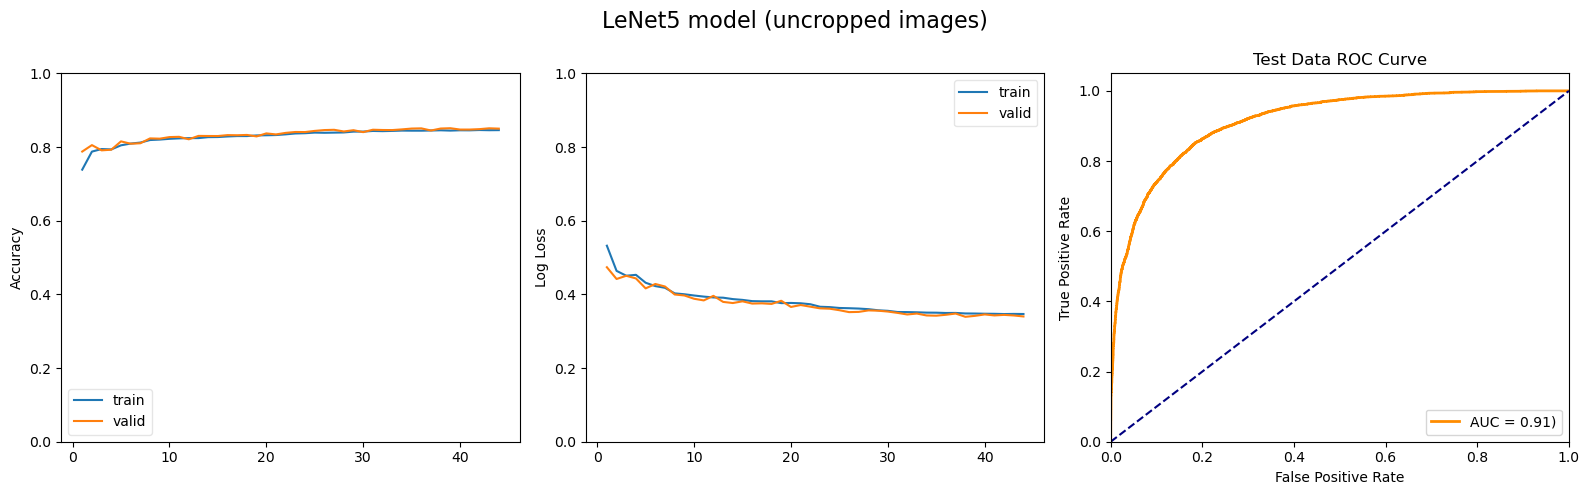

In [17]:
plot_all(history, 'LeNet5 model (uncropped images)', fpr, tpr, roc_auc)

### Utilities Functions for Kaggle Submission

In [21]:
def get_test_gen(test_path, augmented=True):
    test_tif_files = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith('.tif')]
    df_test = pd.DataFrame({'path': test_tif_files})
    df_test['id'] = df_test['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
    if augmented:
        test_image_generator = ImageDataGenerator(rescale=1./255,
                                         vertical_flip = True, 
                                         horizontal_flip = True,
                                         rotation_range = 5, 
                                         zoom_range = 0.1,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1)
    else:
        test_image_generator = ImageDataGenerator(rescale=1./255)
        
    test_gen = test_image_generator.flow_from_dataframe(
                            dataframe=df_test,
                            x_col='path',
                            y_col=None,
                            target_size=(96, 96),
                            class_mode=None,
                            batch_size=256,
                            shuffle=False)
    return test_gen, df_test

In [94]:
def kaggle_submission(model):
    test_path = 'data/test/'
    # make prediction on the non-augmented test images
    test_gen, df_test = get_test_gen(test_path, augmented=False)
    predictions = model.predict(test_gen, verbose=1)
    
    # create a submissions dataframe and store our first predictions (label1)
    submissions = pd.DataFrame({'id': df_test['id'], 'label1': predictions.flatten()})
    
    # make predictions on the augmented test images
    for i in range(3):
        test_gen, _ = get_test_gen(test_path, augmented=True)
        preds = model.predict(test_gen, verbose=1)
        submissions['label'+str(i+2)] = preds.flatten()
    submissions['label'] = submissions[['label1', 'label2', 'label3', 'label4']].mean(axis=1)
    submissions.drop(['label1', 'label2', 'label3', 'label4'], axis=1, inplace=True)
    submissions.to_csv("submission.csv", index=False)
    print('Average Predictions on the Test Data is saved to "submissions.csv"')
    return submissions

In [42]:
submissions = kaggle_submission(lenet5)

Found 57458 validated image filenames.
225/225 [==============================] - 37s 164ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 159s 707ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 158s 704ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 158s 703ms/step
Average Predictions on the Test Data is saved to "submissions.csv"


Kaggle's score on LeNet5 model is: 0.8513

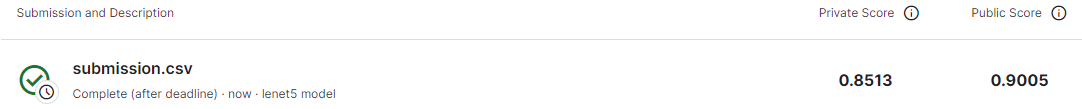

### 4.2. Custom CNN Model

In [8]:
def cnn_model(inputshape, choice=1):
    tf.keras.backend.clear_session()
    model = Sequential(name='CNN')
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=inputshape))    # use default padding: 'valid'
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    if choice == 1:
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
    else:
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

### 4.2.1 Hyperparameter Tuning (number of neurons in Dense layers)

In [30]:
# choice=1: Dense(128)-Dense(64)
CNN_model = cnn_model((32, 32, 3), choice=1)
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                               

In [23]:
CNN_model, data, history, fpr, tpr, roc_auc =  trainer(CNN_model, lr=0.002, img_size=32, batch_size=256, preprocessing_func=crop_center, filename='CNN_model', n_epoch=10, tuning=True)

ImageDataGenerator ..
Found 90000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/10
351/351 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.7232 - auc: 0.7800
Epoch 1: val_accuracy improved from -inf to 0.74753, saving model to .\best_weights_CNN_model.hdf5
351/351 [==============================] - 109s 307ms/step - loss: 0.5643 - accuracy: 0.7232 - auc: 0.7800 - val_loss: 0.5343 - val_accuracy: 0.7475 - val_auc: 0.8047 - lr: 0.0020
Epoch 2/10
351/351 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7919 - auc: 0.8502
Epoch 2: val_accuracy improved from 0.74753 to 0.75432, saving model to .\best_weights_CNN_model.hdf5
351/351 [==============================] - 108s 307ms/step - loss: 0.4674 - accuracy: 0.7919 - auc: 0.8502 - val_loss: 0.5933 - val_accuracy: 0.7543 - val_auc: 0.7832 - l

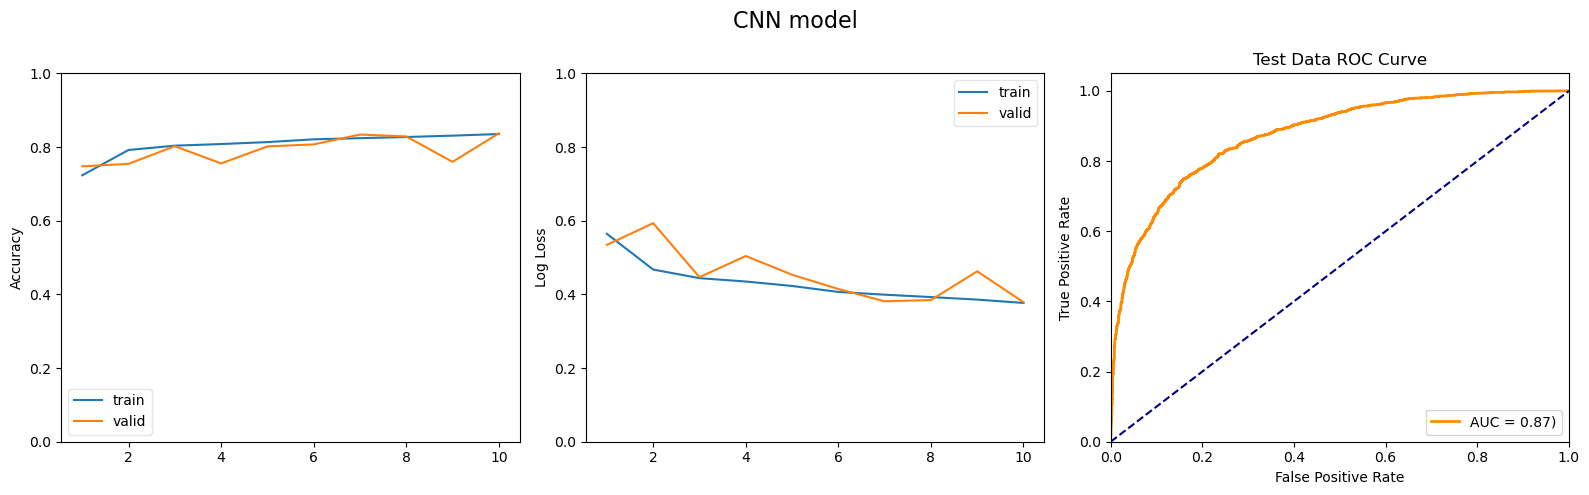

In [24]:
plot_all(history, 'CNN model', fpr, tpr, roc_auc)

In [27]:
# choice=2: Dense(256)-Dense(128)
CNN_model2 = cnn_model((32, 32, 3), choice=2)
CNN_model2.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                               

In [28]:
CNN_model2, data, history, fpr, tpr, roc_auc =  trainer(CNN_model2, lr=0.002, img_size=32, batch_size=256, preprocessing_func=crop_center, filename='CNN_model2', n_epoch=10, tuning=True)

ImageDataGenerator ..
Found 90000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/10
351/351 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6997 - auc: 0.7516
Epoch 1: val_accuracy improved from -inf to 0.63343, saving model to .\best_weights_CNN_model2.hdf5
351/351 [==============================] - 113s 320ms/step - loss: 0.5922 - accuracy: 0.6997 - auc: 0.7516 - val_loss: 0.7887 - val_accuracy: 0.6334 - val_auc: 0.6483 - lr: 0.0020
Epoch 2/10
351/351 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.7870 - auc: 0.8460
Epoch 2: val_accuracy did not improve from 0.63343
351/351 [==============================] - 108s 306ms/step - loss: 0.4741 - accuracy: 0.7870 - auc: 0.8460 - val_loss: 0.7799 - val_accuracy: 0.6219 - val_auc: 0.7167 - lr: 0.0020
Epoch 3/10
351/351 [====================

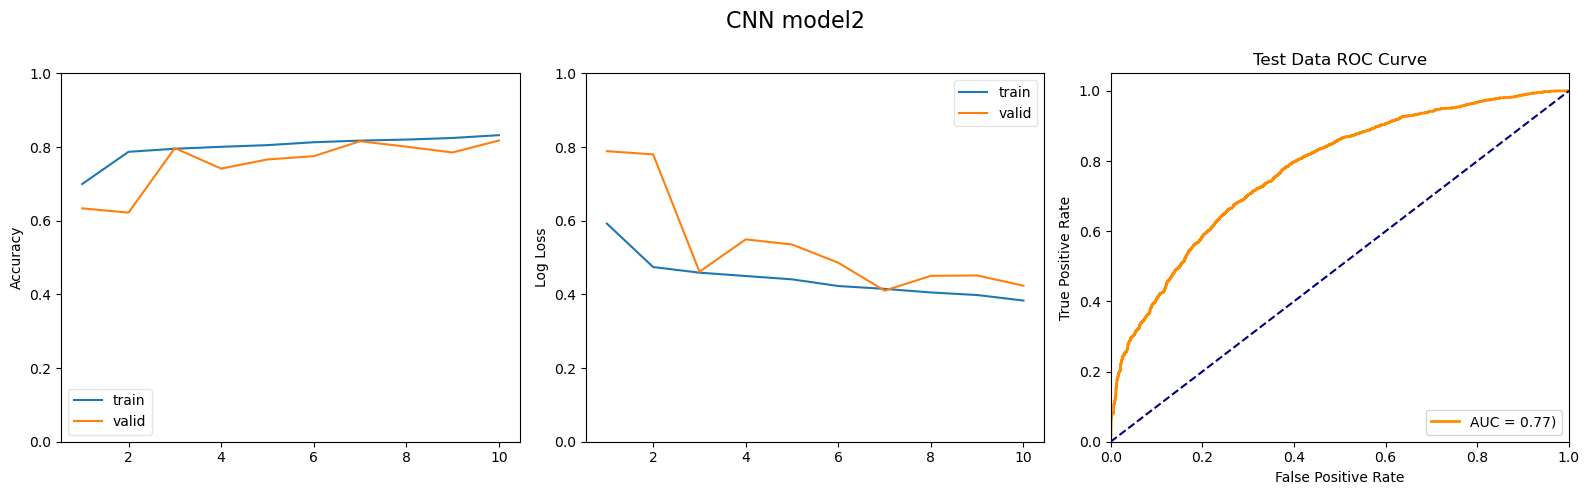

In [29]:
plot_all(history, 'CNN model2', fpr, tpr, roc_auc)

* Test AUC is better for choice 1 (AUC=0.87) compared to choice 2 (AUC=0.77). 
* The validation loss for choice 1 also does not fluctuate as much.

We will use choice 1 architecture for the Dense Layers, and train our CNN model on the whole dataset and on the uncropped images.

In [31]:
CNN_model = cnn_model((96, 96, 3), choice=1)
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     
                                                               

In [33]:
CNN_model, data, history, fpr, tpr, roc_auc =  trainer(CNN_model, lr=0.002, img_size=96, batch_size=256, preprocessing_func=None, filename='CNN_model', n_epoch=50, tuning=False)

ImageDataGenerator ..
Found 198022 validated image filenames belonging to 2 classes.
Found 11002 validated image filenames belonging to 2 classes.
Found 11001 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/50
773/773 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7913 - auc: 0.8525
Epoch 1: val_accuracy improved from -inf to 0.77558, saving model to .\best_weights_CNN_model.hdf5
773/773 [==============================] - 1008s 1s/step - loss: 0.4706 - accuracy: 0.7913 - auc: 0.8525 - val_loss: 0.5360 - val_accuracy: 0.7756 - val_auc: 0.8444 - lr: 0.0020
Epoch 2/50
773/773 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8305 - auc: 0.8962
Epoch 2: val_accuracy improved from 0.77558 to 0.79976, saving model to .\best_weights_CNN_model.hdf5
773/773 [==============================] - 560s 724ms/step - loss: 0.3957 - accuracy: 0.8305 - auc: 0.8962 - val_loss: 0.4712 - val_accuracy: 0.7998 - val_auc: 0.8900 - 

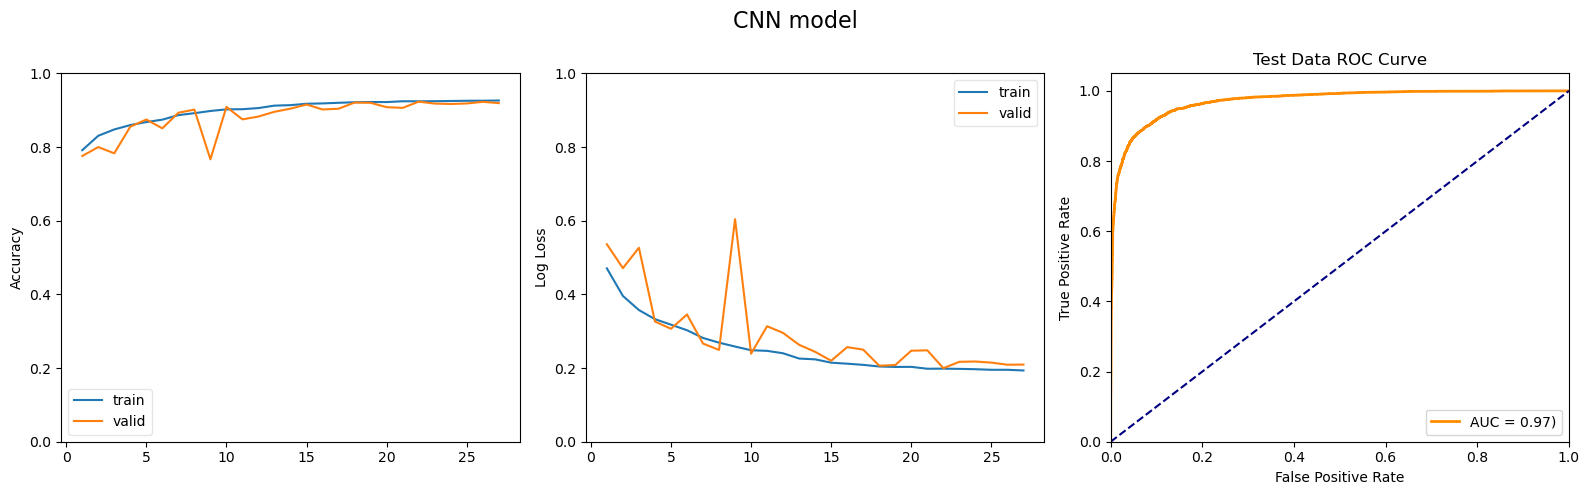

In [35]:
plot_all(history, 'CNN model', fpr, tpr, roc_auc)

Make a Kaggle Submission for this CNN model. 
* We can see from the log that the best model's weights was saved at epoch 22, it achieved the best val_accuracy: 0.9232 and val_auc: 0.9747.
* We will define the same CNN_model structure, then load the weights that we have saved earlier. We are then ready to make predictions on Kaggle test data.

In [47]:
CNN_model.load_weights('best_weights_CNN_model.hdf5')

In [44]:
submissions = kaggle_submission(CNN_model)

Found 57458 validated image filenames.
225/225 [==============================] - 37s 165ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 162s 719ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 158s 704ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 163s 722ms/step
Average Predictions on the Test Data is saved to "submissions.csv"


In [34]:
# Store history for CNN model
df_history = pd.DataFrame(history.history)

# Save history
df_history.to_csv("CNN_history.csv", index=False)

Kaggle's score on custom CNN model is 0.9354

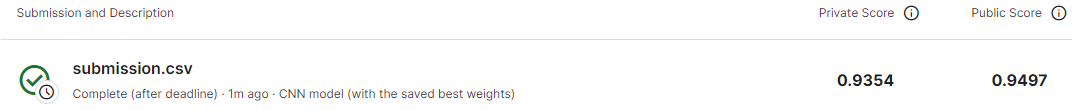

### 4.3. Transfer Learning
### DenseNet169 Base Model - Fine Tuning Convolutional Layer 4 and 5

In [12]:
tf.keras.backend.clear_session()
base_model = DenseNet169(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    if layer.name.startswith('conv4') or layer.name.startswith('conv5'):
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
densenet169_model = Sequential()
densenet169_model.add(base_model)
densenet169_model.add(Dropout(0.5))
densenet169_model.add(Flatten())
densenet169_model.add(BatchNormalization())
densenet169_model.add(Dense(128))
densenet169_model.add(BatchNormalization())
densenet169_model.add(Activation('relu'))
densenet169_model.add(Dropout(0.5))
densenet169_model.add(Dense(64))
densenet169_model.add(BatchNormalization())
densenet169_model.add(Activation('relu'))
densenet169_model.add(Dropout(0.5))
densenet169_model.add(Dense(1, activation='sigmoid'))

In [14]:
densenet169_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 3, 3, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 3, 3, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 14976)             0         
                                                                 
 batch_normalization (BatchN  (None, 14976)            59904     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               1917056   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [18]:
densenet169_model, data, history, fpr, tpr, roc_auc = trainer(densenet169_model, lr=0.002, img_size=96, batch_size=256, preprocessing_func=None, filename='densenet169_model', n_epoch=50, tuning=False)

ImageDataGenerator ..
Found 198022 validated image filenames belonging to 2 classes.
Found 11002 validated image filenames belonging to 2 classes.
Found 11001 validated image filenames belonging to 2 classes.

Training the model ..
Epoch 1/50
773/773 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9072 - auc: 0.9613
Epoch 1: val_accuracy improved from -inf to 0.91629, saving model to .\best_weights_densenet169_model.hdf5
773/773 [==============================] - 603s 754ms/step - loss: 0.2398 - accuracy: 0.9072 - auc: 0.9613 - val_loss: 0.2075 - val_accuracy: 0.9163 - val_auc: 0.9753 - lr: 0.0020
Epoch 2/50
773/773 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9311 - auc: 0.9765
Epoch 2: val_accuracy did not improve from 0.91629
773/773 [==============================] - 581s 752ms/step - loss: 0.1838 - accuracy: 0.9311 - auc: 0.9765 - val_loss: 0.2698 - val_accuracy: 0.8991 - val_auc: 0.9704 - lr: 0.0020
Epoch 3/50
773/773 [==========

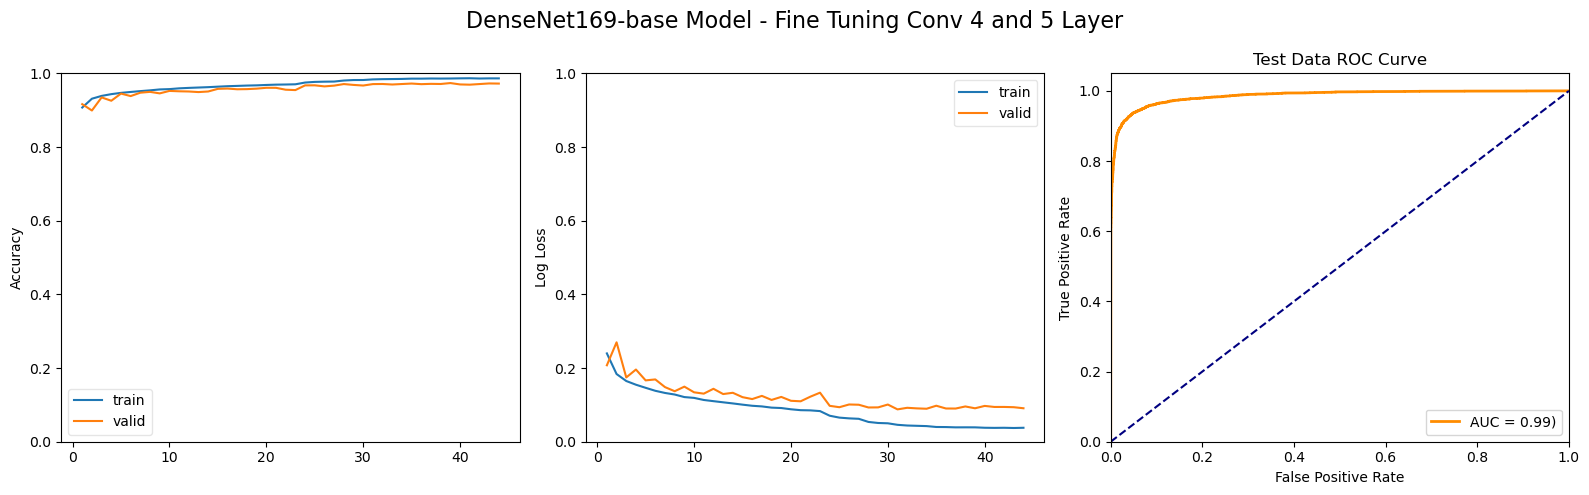

In [19]:
plot_all(history, 'DenseNet169-base Model - Fine Tuning Conv 4 and 5 Layer', fpr, tpr, roc_auc)

In [20]:
# Store history for densenet169 base model (fine tuning Conv4 and Conv5 layers)
df_history = pd.DataFrame(history.history)

# Save history
df_history.to_csv("densenet169_Conv4_5_tuning_history.csv", index=False)

In [25]:
densenet169_model.load_weights('best_weights_densenet169_model.hdf5')

In [28]:
submissions = kaggle_submission(densenet169_model)

Found 57458 validated image filenames.
225/225 [==============================] - 37s 166ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 158s 702ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 155s 688ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 155s 690ms/step
Average Predictions on the Test Data is saved to "submissions.csv"


Kaggle's Score on transfer learning with DenseNet169 as base model is 0.9372

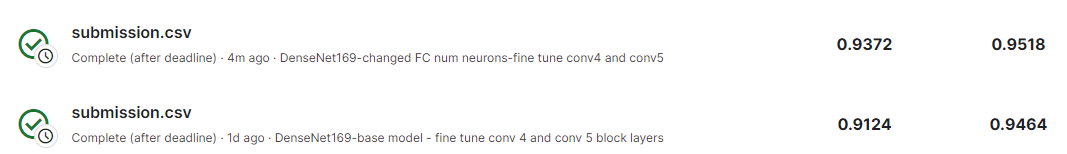

### 4.4. Assembled Model
I assembled two already implemented models: a Custom CNN model and a DenseNet169 model. I then weighted the predictions from each model, resulting in the best score among my models on Kaggle: 0.9532

In [96]:
# save predictions from DenseNet169 model
predictions_densenet = submissions['label'].tolist()

In [97]:
# define CNN custom model and load the best weights that we have already saved
CNN_model = cnn_model((96, 96, 3), choice=1)
CNN_model.load_weights('best_weights_CNN_model.hdf5')

In [98]:
# make predictions
submissions2 = kaggle_submission(CNN_model)

Found 57458 validated image filenames.
225/225 [==============================] - 38s 168ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 164s 730ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 162s 720ms/step
Found 57458 validated image filenames.
225/225 [==============================] - 159s 705ms/step
Average Predictions on the Test Data is saved to "submissions.csv"


In [99]:
predictions_cnn = submissions2['label'].tolist()

In [101]:
predictions_assembled = 0.3 * np.array(predictions_densenet) + 0.7 * np.array(predictions_cnn)

In [102]:
subs = submissions[['id']].copy()
subs['label'] = predictions_assembled
subs.to_csv('submissions', index=False)

Kaggle's leaderboard screen shot on the assembled model:

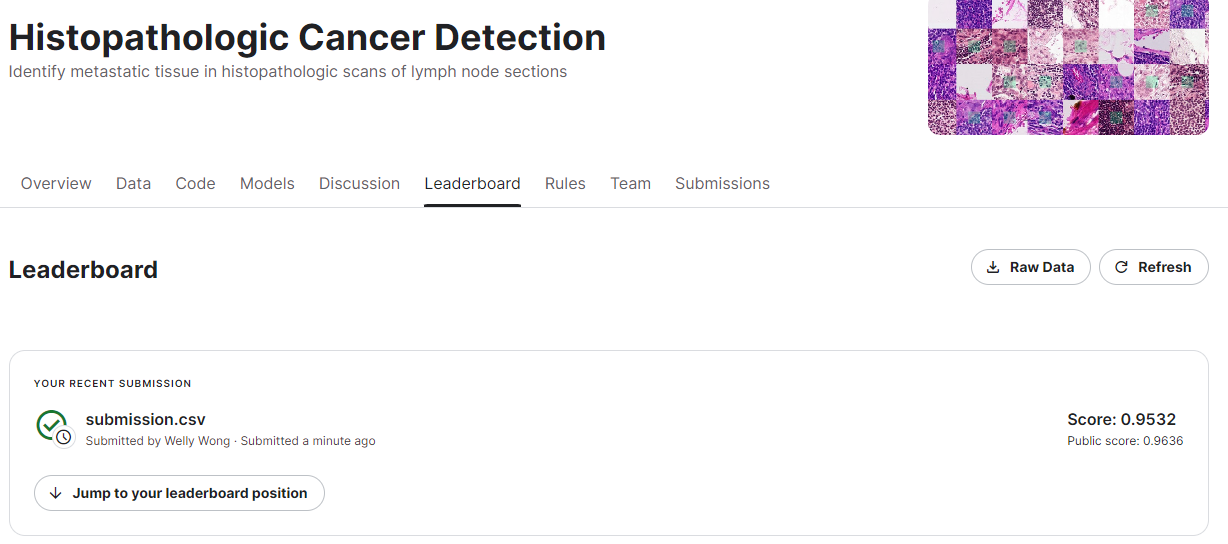

### 4.5. Results

In [125]:
lenet5_metrics = np.load('lenet5-metrics.npz')
cnn_metrics = np.load('CNN_model-metrics.npz')
densenet169_metrics = np.load('densenet169_model-metrics.npz')

In [109]:
lenet5_history = pd.read_csv('lenet5_history.csv')
cnn_history = pd.read_csv('CNN_history.csv')
densenet169_history = pd.read_csv('densenet169_Conv4_5_tuning_history.csv')

In [115]:
results_df = pd.DataFrame({'Model': ['LeNet5', 'CNN', 'DenseNet169'],
                          'Validation_Loss': [list(lenet5_history['val_loss'])[-1], list(cnn_history['val_loss'])[-1], list(densenet169_history['val_loss'])[-1]],
                          'Validation_Accuracy': [list(lenet5_history['val_accuracy'])[-1], list(cnn_history['val_accuracy'])[-1], list(densenet169_history['val_accuracy'])[-1]],
                          'Validation_AUC': [list(lenet5_history['val_auc'])[-1], list(cnn_history['val_auc'])[-1], list(densenet169_history['val_auc'])[-1]]})

In [116]:
results_df

Model  Validation_Loss  Validation_Accuracy  Validation_AUC
0       LeNet5         0.340022             0.849888        0.924884
1          CNN         0.209382             0.919178        0.972400
2  DenseNet169         0.090846             0.972191        0.993583

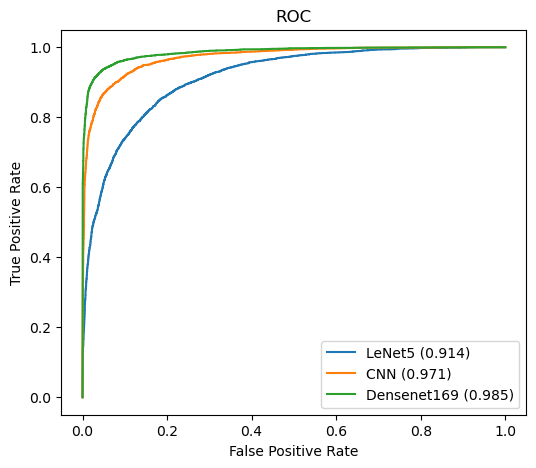

In [127]:
plt.figure(figsize=(6, 5))
plt.plot(lenet5_metrics['fpr'], lenet5_metrics['tpr'], label='LeNet5 ({:.3f})'.format(lenet5_metrics['roc_auc']))
plt.plot(cnn_metrics['fpr'], cnn_metrics['tpr'], label='CNN ({:.3f})'.format(cnn_metrics['roc_auc']))
plt.plot(densenet169_metrics['fpr'], densenet169_metrics['tpr'], label='Densenet169 ({:.3f})'.format(densenet169_metrics['roc_auc']))
plt.legend()
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Observations on each model performances:
* Custom CNN performs better than LeNet5. It has more layers and more number of parameters. It is more suited to our complex histopathologic lymph node scans data. While LeNet5 was developed for digit recognition.
* Transfer Learning with DenseNet169 base model also performs well, it has the best ROC score for the test data that we set aside (this test data comes from training set, not the test data on Kaggle)
* CNN model performs slightly better than DenseNet169 model on Kaggle.

Hyperparameters tuning result:
* LeNet5: learning rate tuning results were comparable. Learning rate values: [0.002, 0.001, 0.0005] were tested. I decided to use learning rate = 0.002, considering that ReduceLROnPlateau() method is added to Keras Callbacks.
* CNN: tuning the number of neurons in the fully connected layers resulted in the configuration of 128-64 being identified as the better choice.

## 5. Conclusion
* Training NN requires a significant amount of time and computational resources due to the complex calculations involved in optimizing the network's parameters.
* There are many hyperparameters that need to be tuned, such as learning rate, batch size, and network architecture, which can significantly impact the performance of the model.
* Observing other people's work on similar or the same dataset can provide valuable insights and serve as a baseline for building and improving upon our own models.

What did and did not help improve the performance of the models:
* Increasing the number of neurons in the Fully Connected layers did not help. The 128-64 configuration, when compared to the 256-128 configuration, results in better AUC, as well as less fluctuation in validation loss and validation accuracy.
* Since we are predicting a probability that the center 32x32px region of a patch contains at least one pixel of tumor tissue, wouldn't it make sense to crop our image to that region only? The results with center-cropped (32x32 px) images showed worse performance than with 96x96 px. Clearly, the area surrounding center region helped in our classification task.
* Weighted predictions from DenseNet169 model and Custom CNN model resulted in improved predictions on Kaggle test data.
* Test time augmentation (TTA) and averaging inferences improved the outcomes on Kaggle.

What improvements could we try in the future?
* Our image dataset is relatively small compared to ImageNet, the dataset on which DenseNet169 was trained. I think our transfer learning model (with fine tuning earlier layers in the DenseNet169 base model) can accommodate more data without overfitting. Training with additional images may help improve performance.
* Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used for visualizing and understanding the decisions made by a convolutional neural network (CNN) by highlighting the regions of the input image that are important for the network's prediction. It works by finding the final convolutional layer in the network and then examining the gradient information flowing into that layer. The output of Grad-CAM is a heatmap visualization for a given class label. We can use this heatmap to visually verify where in the image the CNN is looking. We may be able to gain valuable insights into the features and regions of interest within our histopathologic scans of lymph nodes images that contribute to our classification decisions.

## References
* Andrew Ng. DeepLearningAI. Convolutional Neural Networks (Course 4 of the Deep Learning Specialization) [Youtube Playlist](https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF)
* Adarsh Vulli, Parvathaneni Naga Srinivasu, Madipally Sai Krishna Sashank, Jana Shafi, Jaeyoung Choi, and Muhammad Fazal Ijaz. NIH Article. Fine-Tuned DenseNet-169 for Breast Cancer Metastasis Prediction Using FastAI and 1-Cycle Policy [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9025766/)
* Andrew Presland. Github repository: histopathologic-cancer-detection [Link](https://github.com/apresland/histopathologic-cancer-detection/tree/main)
* Stackoverflow. Image Data Generator [Link](https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset)
* Joni Juvonen. Kaggle. A complete ML pipeline [Link](https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai)